You must install the tqdm library to use progress indicators with emcee


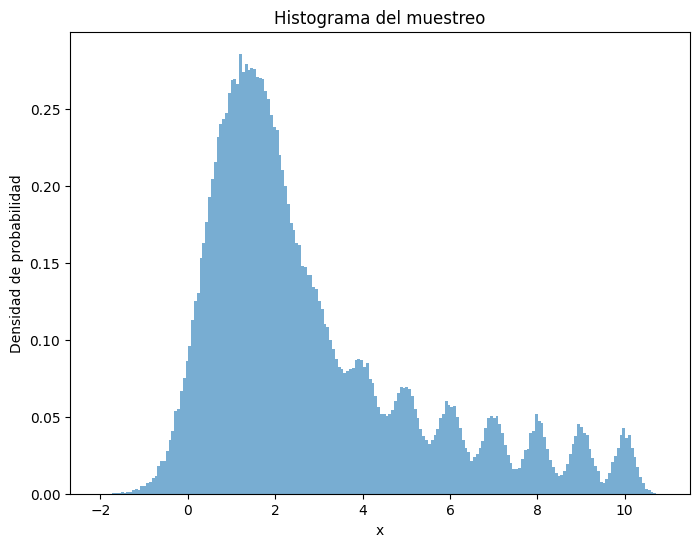

1.b) A = 4.01744501 ± 0.02238854


In [ ]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

# Función log-probabilidad para emcee: se extrae el parámetro escalar
def log_prob(theta, n=10, alpha=4/5):
    x = theta[0]
    k = np.arange(1, n+1)
    suma = np.sum(np.exp( - (x - k)**2 * k ) / (k**alpha))
    return np.log(suma)

# Parámetros de la simulación
N_total = 500000
N_caminantes = 20
N_pasos = int(np.ceil(N_total / N_caminantes))
dim = 1

# Posición inicial de los walkers
posicion_0 = np.random.randn(N_caminantes, dim)

# Configuración del sampler
sampler = emcee.EnsembleSampler(N_caminantes, dim, log_prob)
sampler.run_mcmc(posicion_0, N_pasos, progress=True)

# Extraer y aplanar las muestras a un array 1D
samples = sampler.get_chain(flat=True)[:, 0]

""""
plt.figure(figsize=(8,6))
plt.hist(samples, bins=200, density=True, alpha=0.6)
plt.xlabel("x")
plt.ylabel("Densidad de probabilidad")
plt.title("Histograma del muestreo")
plt.savefig("1.a.pdf")
plt.show()
"""

# Función g(x) definida vectorialmente
def g(x, n=10, alpha=4/5):
    x = np.atleast_1d(x)[:, None]
    k = np.arange(1, n+1)
    return np.sum(np.exp( - (x - k)**2 * k ) / (k**alpha), axis=1)

# Función f(x)
def f(x):
    return np.exp(-x**2)

# --- Cálculo de A y su incertidumbre ---
N = len(samples)
g_vals = g(samples)
f_vals = f(samples)

# ratio_i = f(x_i) / g(x_i)
ratio = f_vals / g_vals

# Promedio Q = (1/N) * sum(ratio)
Q = np.mean(ratio)

# Estimación de A
A_est = np.sqrt(np.pi) / Q

# Varianza de ratio (usamos ddof=1 para una estimación insesgada)
var_ratio = np.var(ratio, ddof=1)

# Desviación estándar de Q
sigma_Q = np.sqrt(var_ratio / N)

# Propagación de errores para A = sqrt(pi)/Q
sigma_A = (np.sqrt(np.pi) / Q**2) * sigma_Q

print(f"1.b) A = {A_est:.8f} ± {sigma_A:.8f}")


## Ejercicio 2

In [ ]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

# Parámetros (todos en cm)
D1 = 50.0            # Distancia de la fuente a las rendijas
D2 = 50.0            # Distancia de las rendijas a la pantalla
lamb = 6.7e-5        # Longitud de onda: 670 nm = 6.7e-5 cm
A = 0.04             # Ancho de la apertura de la fuente: 0.4 mm = 0.04 cm
a = 0.01             # Ancho de cada rendija: 0.1 mm = 0.01 cm
d = 0.1              # Separación entre rendijas: 0.1 cm

# Dominio para x: la apertura de la fuente centrada en 0
x_min, x_max = -A/2, A/2

# Dominio para y: las dos rendijas. Se asume que están centradas en -d/2 y +d/2.
# Cada rendija tiene ancho 'a' (se extienden ±a/2 alrededor del centro)
y_left = (-d/2 - a/2, -d/2 + a/2)    # Rendija izquierda
y_right = ( d/2 - a/2,  d/2 + a/2)     # Rendija derecha

# Definición de la función log_prob para emcee.
# Se devuelve 0 si (x, y) está en la región permitida (dominio uniforme), y -np.inf en otro caso.
def log_prob(theta):
    x, y = theta
    if (x < x_min) or (x > x_max):
        return -np.inf
    if not ((y_left[0] <= y <= y_left[1]) or (y_right[0] <= y <= y_right[1])):
        return -np.inf
    return 0.0

# Configuración del muestreador MCMC:
# Queremos N = 100,000 muestras. Usamos nwalkers caminantes y nsteps iteraciones tal que nwalkers * nsteps ~ 100,000.
nwalkers = 50
nsteps = 2000  # 50 * 2000 = 100,000 muestras

# Inicializamos los walkers.
# Para x se toma uniformemente en [x_min, x_max].
# Para y, se inicializa la mitad de los walkers en la rendija izquierda y la otra mitad en la rendija derecha.
initial_positions = []
for i in range(nwalkers):
    x0 = np.random.uniform(x_min, x_max)
    if i < nwalkers/2:
        y0 = np.random.uniform(y_left[0], y_left[1])
    else:
        y0 = np.random.uniform(y_right[0], y_right[1])
    initial_positions.append([x0, y0])
initial_positions = np.array(initial_positions)

# Crear y ejecutar el sampler de emcee.
sampler = emcee.EnsembleSampler(nwalkers, 2, log_prob)
sampler.run_mcmc(initial_positions, nsteps, progress=True);

# Descarta una parte de la cadena como burn-in (por ejemplo, los primeros 200 pasos)
burn = 200
samples = sampler.get_chain(discard=burn, flat=True)  # forma: (nwalkers*(nsteps-burn), 2)

# Extraemos las muestras para x y y
x_samples = samples[:, 0]
y_samples = samples[:, 1]

# Definición de la función integrando para un valor dado de z.
# La integral (omitiendo el factor de fase global) es:
#   ψ(z) = ∫∫ exp[i π/(λ D1) ((x-y)^2 + (z-y)^2)] dx dy
# Se calcula la media sobre las muestras; la intensidad es |ψ(z)|^2.
def integrand(x, y, z):
    phase = np.pi/(lamb * D1) * ((x - y)**2 + (z - y)**2)
    return np.exp(1j * phase)

# Definir un conjunto de valores de z en el intervalo (-0.4, 0.4) cm
z_values = np.linspace(-0.4, 0.4, 200)
I_num = np.zeros_like(z_values, dtype=float)

# Para cada z se calcula la integral aproximada por Monte Carlo.
for i, z in enumerate(z_values):
    f_vals = integrand(x_samples, y_samples, z)
    amp = np.mean(f_vals)  # Promedio sobre las muestras
    I_num[i] = np.abs(amp)**2

# Normalizamos la intensidad numérica dividiendo por su máximo.
I_num_norm = I_num / np.max(I_num)

# -------------------------------
# Modelo clásico:
# Según la teoría clásica, la intensidad es:
# I_clásico(z) ∝ cos²[ (π d/λ) sinθ ] · [sinc((a/λ) sinθ)]²
# donde θ = arctan(z/D2) y sinc(x) = sin(x)/x (con sinc(0)=1).
theta = np.arctan(z_values / D2)
def sinc(x):
    return np.where(x == 0, 1.0, np.sin(x) / x)

I_class = (np.cos(np.pi * d / lamb * np.sin(theta)))**2 * (sinc(a / lamb * np.sin(theta)))**2
I_class_norm = I_class / np.max(I_class)

# -------------------------------
# Graficamos ambas intensidades
plt.figure(figsize=(8, 6))
plt.plot(z_values, I_num_norm, label="Integral de camino (emcee)")
plt.plot(z_values, I_class_norm, label="Modelo clásico", linestyle="--")
plt.xlabel("z (cm)")
plt.ylabel("Intensidad normalizada")
plt.title("Difracción de Fresnel: Integral de camino vs Modelo clásico")
plt.legend()
plt.grid(True)
plt.savefig("2.pdf")
plt.show()
